<h1><center>Programming Exercise 7:<br>K-means Clustering and Principal Component Analysis</center></h1>

In [1]:
from scipy.io import loadmat
from scipy.misc import imread 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random

mpl.rcParams['figure.figsize'] = (10,6)

# 1. K-means Clustering
- Implement the K-means algorithm and use it for image compression. First start on an example 2D dataset to gain an intuition of how the algorithm works
- Afterwards, use K-means for image compression by reducing the number of colors that occur in an image to only those that are the most common in that image

## 1.1 Implementing K-means

In [2]:
data1 = loadmat('ex7data2.mat')
X = data1['X'] # no need to add the bias terms, as convention for K-means
               # there are 300 samples with 2 features each

- Initially we choose 3 centroids and initialize them as given in ex7.m:

In [15]:
K = 3 # 3 centroids
initial_centroids = np.array([[3,3],[6,2],[8,5]]) # centroid coordinates

In [4]:
def findClosestCentroids(X,centroids):
    '''
    Computes L2 squared norm of every sample in design matrix X to each centroid in centroids
    Finds the minimum distance for every sample and returns the label to the closest centroid
    
    Parameters
    ------------
    X: m by n design matrix
    centroids: K by n centroid matrix with n-coordinates for each of the K centroids
    
    Returns
    ------------
    idx: 1D m-dimensional array with labels of closest centroid for all samples
    '''
    
    K = centroids.shape[0] # number of centroids
    m,num_feats = X.shape # number of samples and features
    norm_array = np.empty((m,K)) # initialize norm array, K L2 squared norm per sample
    
    for ii_idx,ii_centroid in enumerate(centroids): # iterate through centroids
        ii_diff_array = X-ii_centroid # compute vector distance to centroid for all samples
        norm_array[:,ii_idx] = np.linalg.norm(ii_diff_array,axis=1)**2 # compute L2 squared norms for all samples
    
    idx = np.argmin(norm_array,axis=1) # indices of min distance along 3rd axis, i.e all centroids
    
    return idx

- Find closest centroids to the first 3 samples:

In [5]:
idx = findClosestCentroids(X,initial_centroids)

print('Closest centroids for the first 3 examples:')
print(idx[:3]+1) # + 1 because we index starting with 0 and the homework is labeing centroids starting with 1

Closest centroids for the first 3 examples:
[1 3 2]


- Now write a function to compute the mean of the centroids from all points assigned to them respectively:

In [6]:
def computeCentroids(X,idx,K):
    '''
    Computes new centroids by averaging over all samples assigned to clusters
    
    Parameters
    ------------
    X: m by n design matrix
    idx: 1D m-dimensional array with labels of closest centroid for all samples
    K: number of clusters
    
    Returns
    ------------
    new_centroids: K by n matrix of new centroids
    '''
    
    new_centroids = np.empty((K,X.shape[1])) # allocate space for new centroids
    
    for ii_centroid in range(K): # loop through centroids
        ii_centroid_cut = [idx==ii_centroid] # cut for samples assigned to centroid
        ii_X = X[ii_centroid_cut] # design matrix of all samples assigned to centroid
        ii_avg_centroid = np.average(ii_X,axis=0) # average of features (along columns) for this centroid's design matrix
        new_centroids[ii_centroid,:] = ii_avg_centroid # save centroid
    
    return new_centroids

- Compute means based on the closest centroids found in the previous part:

In [7]:
centroids = computeCentroids(X,idx,K)

print('Centroids computed after initial finding of closest centroids:')
print(centroids)

Centroids computed after initial finding of closest centroids:
[[ 2.42830111  3.15792418]
 [ 5.81350331  2.63365645]
 [ 7.11938687  3.6166844 ]]


## 1.2 K-means on Example Dataset
- Run K-means on a toy 2D dataset
- Define the algorithm:

In [8]:
def runkMeans(X,initial_centroids,max_iters):
    '''
    Runs K-Means algorithm on data in design matrix X for max_iters iterations
    
    Parameters
    ------------
    X: m by n design matrix
    initial_centroids: K by n centroid matrix with n-coordinates for each of the K initial centroids
    max_iters: number of iterations for K-Means algorithm
    
    Returns
    ------------
    centroids: 3D array of K by n by max_iters+1 dimensions. One 2D array of centroids for each iteration
    idx: 1D m-dimensional array with labels of closest centroid for all samples
    '''
    
    K = initial_centroids.shape[0] # number of centroids
    m,num_feats = X.shape # number of samples and features
    centroids = np.empty((K,num_feats,max_iters+1)) # centroid history 3D array
                                                    # one 2D array per iteration, +1 because we include the initial guess
    centroids[:,:,0] = initial_centroids # save initial centroid guess
        
    for ii_iter in range(max_iters): # K-Means iteration
        idx = findClosestCentroids(X,centroids[:,:,ii_iter])
        centroids[:,:,ii_iter+1] = computeCentroids(X,idx,K)
        
    return centroids,idx

In [16]:
max_iters = 10
centroids, idx = runkMeans(X,initial_centroids,max_iters)

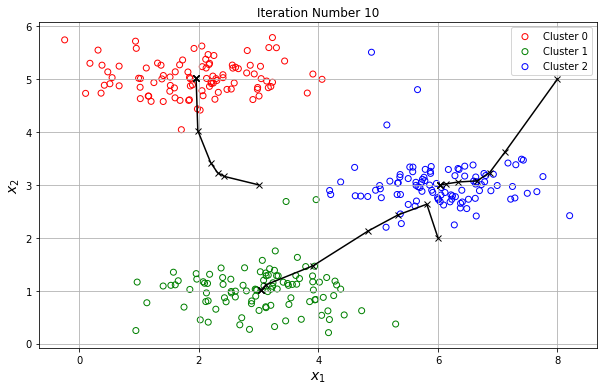

In [17]:
plt.figure()
plt.grid()
plt.scatter(X[:,0][idx==0],X[:,1][idx==0],marker='o',edgecolors='r',facecolors='none',label='Cluster 0')
plt.scatter(X[:,0][idx==1],X[:,1][idx==1],marker='o',edgecolors='g',facecolors='none',label='Cluster 1')
plt.scatter(X[:,0][idx==2],X[:,1][idx==2],marker='o',edgecolors='b',facecolors='none',label='Cluster 2')
plt.plot(centroids[0,0,:],centroids[0,1,:],linestyle='-',marker='x',color='k')
plt.plot(centroids[1,0,:],centroids[1,1,:],linestyle='-',marker='x',color='k')
plt.plot(centroids[2,0,:],centroids[2,1,:],linestyle='-',marker='x',color='k')
plt.legend()
plt.xlabel(r'$x_1$',fontsize=14)
plt.ylabel(r'$x_2$',fontsize=14)
plt.title('Iteration Number {}'.format(max_iters))
plt.show()

## 1.3 Random Initialization
- Implement a function to randomly initialize centroids for K-Means algorithm
- A good strategy for initializing the centroids is to select them as random samples from the training set. The procedure:
    - Randomly permute the indices of the samples
    - Then select K samples 

In [11]:
def kMeansInitCentroids(X,K):
    '''
    Initializes centroids by randomly choosing K samples from design matrix X
    
    Parameters
    ------------
    X: m by n design matrix
    K: number of clusters
    
    Returns
    ------------
    initial_centroids: K by n centroid matrix with n-coordinates for each of the K initial centroids
    '''
    
    m,num_feats = X.shape # number of samples and features
    rand_ind = random.sample(range(m),K) # choose K indices at random from design matrix X
    initial_centroids = X[rand_ind] # save those random samples as initial centroids
    
    return initial_centroids

- Now let's test it by trying clustering as above but with the random initialization:

In [18]:
initial_centroids = kMeansInitCentroids(X,K)
centroids, idx = runkMeans(X,initial_centroids,max_iters)

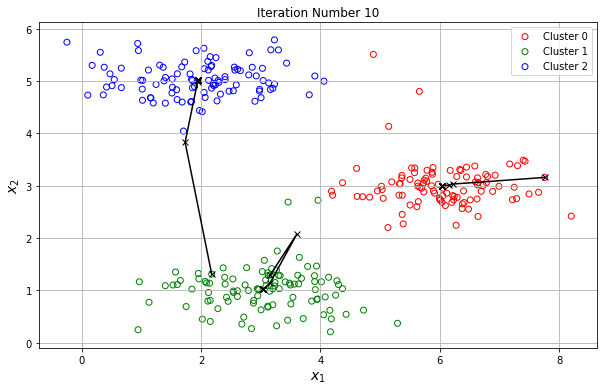

In [20]:
plt.figure()
plt.grid()
plt.scatter(X[:,0][idx==0],X[:,1][idx==0],marker='o',edgecolors='r',facecolors='none',label='Cluster 0')
plt.scatter(X[:,0][idx==1],X[:,1][idx==1],marker='o',edgecolors='g',facecolors='none',label='Cluster 1')
plt.scatter(X[:,0][idx==2],X[:,1][idx==2],marker='o',edgecolors='b',facecolors='none',label='Cluster 2')
plt.plot(centroids[0,0,:],centroids[0,1,:],linestyle='-',marker='x',color='k')
plt.plot(centroids[1,0,:],centroids[1,1,:],linestyle='-',marker='x',color='k')
plt.plot(centroids[2,0,:],centroids[2,1,:],linestyle='-',marker='x',color='k')
plt.legend()
plt.xlabel(r'$x_1$',fontsize=14)
plt.ylabel(r'$x_2$',fontsize=14)
plt.title('Iteration Number {}'.format(max_iters))
plt.show()

## 1.4 Image Compression with K-means
- Apply K-Means to image compression to a 24-bit color image
- In each of these images, a pixel is represented by three 8-bit unsigned integers (ranging from 0-255) that specify the red, green and blue intensity values; this encoding is refered to as RGB
- The sample image has thousands of colors and here we'll reduce it to only 16 colors
- We will treat every pixel in the original image as a data sample and use the K-Means algorithm to find the 16 colors that best group (cluster) the pixels in the 3-dimensional RGB space
- Once we have computed the cluster centroids on the image, we will use the 16 colors to replce the pixels in the original image

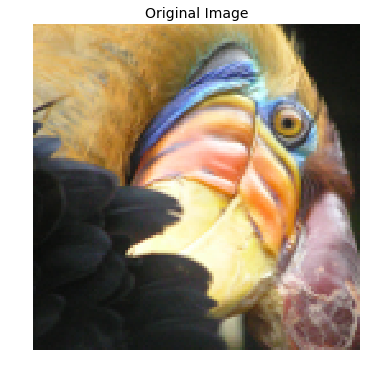

In [50]:
A = imread('bird_small.png') # load bird image
og_imshape = A.shape
# Shape is (128,128,3) makes sense since the image is 128x128 pixels RGB

# Show the original image
plt.figure()
plt.imshow(A) 
plt.axis('off')
plt.title('Original Image',fontsize=14)
plt.show()

A = A/255 # Divide by 255 so that all values are in the range 0-1

A = np.reshape(A,(A.shape[0]*A.shape[1],3)) # reshape into design matrix
                                            # shape will be (128*128=)16384 by 3

In [51]:
K = 16 # we want 16 clusters for compression
max_iters = 10 

initial_centroids = kMeansInitCentroids(A,K) # get random initial centroids from samples

centroids,idx = runkMeans(A,initial_centroids,max_iters) # run K-Means

- Now recover the image from the indices (idx) by mapping each pixel (specified by its index in idx) to the centroid value:

In [52]:
X_recovered = centroids[:,:,-1][idx] # each sample (pixel) has been assigned to a cluster, labeled in idx
                                     # let's represent each sample by the centroid is has been assigned to
X_recovered = np.reshape(X_recovered,(og_imshape[0],og_imshape[1],3)) # reshape into orignal image shape

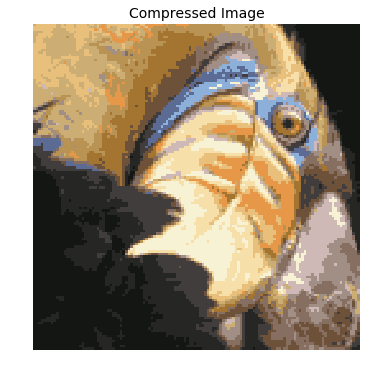

In [53]:
# Show compressed image
plt.figure()
plt.imshow(X_recovered) 
plt.axis('off')
plt.title('Compressed Image',fontsize=14)
plt.show()

- Note that the original image required 24 bits for each one of the 128 by 128 pixel locations so in total $128\times128\times24=393,216$ bits
- The new representation requires some overhead storage in the form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel so in total $16\times24+128\times128\times4=65,920$ bits thus we have compressed the image by about a factor of 6

## 1.5 Optional Exercise: Use Your Image
- Run K-Means on "my own" image
- I'll choose Pollock's Circumcision since it has a myriad of colors...and it's also on of my favourite paintings
- Let's try a smaller number of clusters (colors) than 16, how about 5?

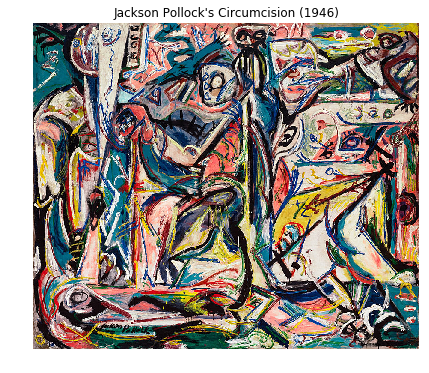

In [66]:
A = imread('pollock_circumcision.jpg') # load bird image
og_imshape = A.shape # shape is (763, 902, 3)

# Show the original image
plt.figure()
plt.imshow(A) 
plt.axis('off')
plt.title("Jackson Pollock's Circumcision (1946)",fontsize=12)
plt.show()

A = A/255 # Divide by 255 so that all values are in the range 0-1

A = np.reshape(A,(A.shape[0]*A.shape[1],3)) # reshape into design matrix
                                            # shape will be (128*128=)16384 by 3

In [70]:
K = 7 # we want 16 clusters for compression
max_iters = 10 

initial_centroids = kMeansInitCentroids(A,K) # get random initial centroids from samples

centroids,idx = runkMeans(A,initial_centroids,max_iters) # run K-Means

In [71]:
X_recovered = centroids[:,:,-1][idx] # each sample (pixel) has been assigned to a cluster, labeled in idx
                                     # let's represent each sample by the centroid is has been assigned to
X_recovered = np.reshape(X_recovered,(og_imshape[0],og_imshape[1],3)) # reshape into orignal image shape

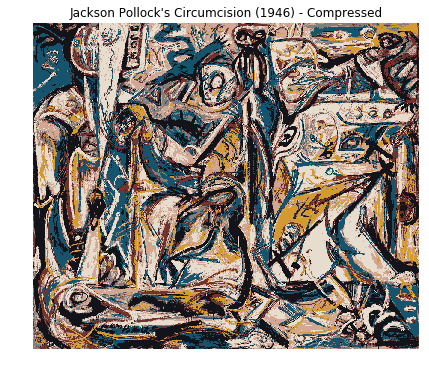

In [72]:
# Show compressed image
plt.figure()
plt.imshow(X_recovered) 
plt.axis('off')
plt.title("Jackson Pollock's Circumcision (1946) - Compressed",fontsize=12)
plt.show()

# 2. Principal Component Analysis

## 2.1 Example Dataset

## 2.2 Implementing PCA

## 2.3 Dimensionality Reduction with PCA

## 2.4 Face Image Dataset

## 2.5 Optional Exercise: PCA for Visualization 